In [1]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import os
import datacube
import pickle
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from IPython.display import Image

from datacube.utils.geometry import Geometry
from datacube.utils.cog import write_cog
from deafrica_tools.plotting import xr_animation
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize

In [2]:
# Set up a Dask cluster.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33503 Dashboard: /user/victoria@kartoza.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [3]:
# Connect to the datacube to access DE Africa data.
# The `app` parameter is a unique name for the analysis which is based on the notebook file name.
dc = datacube.Datacube(app="NDVI_Classification")

In [4]:
# Set important parameters for the analysis.

# Set the bands/measurements of the satellite data to load.
measurements = ["red", "green", "blue", "nir"]

# Set the time period of interest for your analysis.
time_range = ("2014", "2019")

# Select the initial and follow up year for the change detection.
initial_year = "2015"
followup_year = "2019"

# Set the x and y cell resolution of the satellite data.
# If loading a large area, then increase the resolution so the data will fit into memory.
# Used the same resolution as the CCI.
resolution = (-300, 300)

# Set the Coordinate Reference System (CRS) the satellite data is to be reprojected to.
output_crs = "EPSG:6933"

dask_chunks = dict(x=1000, y=1000)

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Load the African Countries GeoJSON.
# This file contains polygons for the boundaries of African countries.
african_countries = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

# List the countries in the African Countries GeoJSON.
np.unique(african_countries["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [6]:
# Select an African country to carry out the analysis over.
country = "Tunisia"

# The country selected needs to be transformed into a geometry object to be used in the dc.load() function.
idx = african_countries[african_countries["COUNTRY"] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

In [7]:
# Create a reusable datacube query object.
query = {"geopolygon": geom,
         "time": time_range,
         "resolution": resolution,
         "output_crs": output_crs,
         "dask_chunks": dask_chunks}

In [8]:
# Load available Landsat 8 Annual GeoMAD data.
ds = dc.load(product="gm_ls8_annual", measurements=["red", "green", "blue", "nir"], **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 6, y: 2522, x: 1311)
Coordinates:
  * time         (time) datetime64[ns] 2014-07-02T11:59:59.999999 ... 2019-07...
  * y            (y) float64 4.442e+06 4.441e+06 ... 3.686e+06 3.685e+06
  * x            (x) float64 7.262e+05 7.264e+05 ... 1.119e+06 1.119e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [9]:
# Mask the Landsat GeoMAD dataset with the country polygon.
african_countries = african_countries.to_crs(output_crs)
mask = xr_rasterize(african_countries[african_countries["COUNTRY"] == country], ds)
ds = ds.where(mask)

In [10]:
# Calculate the NDVI spectral index and add it to the loaded Landsat GeoMAD dataset.
ds = calculate_indices(ds, "NDVI", satellite_mission="ls")
# Get the NDVI xarray.DataArray.
ds_ndvi = ds.NDVI.compute()

In [11]:
# Export the NDVI dataset for each year as as a GeoTIFF.

# Loop through each year of the data. 
for i in range(len(ds_ndvi.time)):
    # Get the data for a single year.
    singleTimestamp = ds_ndvi.isel(time=i)
    year = singleTimestamp.time.dt.strftime('%Y').data
    # Define the file name for the GeoTIFF.
    fname = f"{output_dir}/{year}_{country.replace(' ', '')}_ndvi.tif"
    print(f'Writing {fname}')
    # Write the GeoTIFF. 
    write_cog(singleTimestamp, fname=fname, overwrite=True)

Writing results/2014_Tunisia_ndvi.tif
Writing results/2015_Tunisia_ndvi.tif
Writing results/2016_Tunisia_ndvi.tif
Writing results/2017_Tunisia_ndvi.tif
Writing results/2018_Tunisia_ndvi.tif
Writing results/2019_Tunisia_ndvi.tif


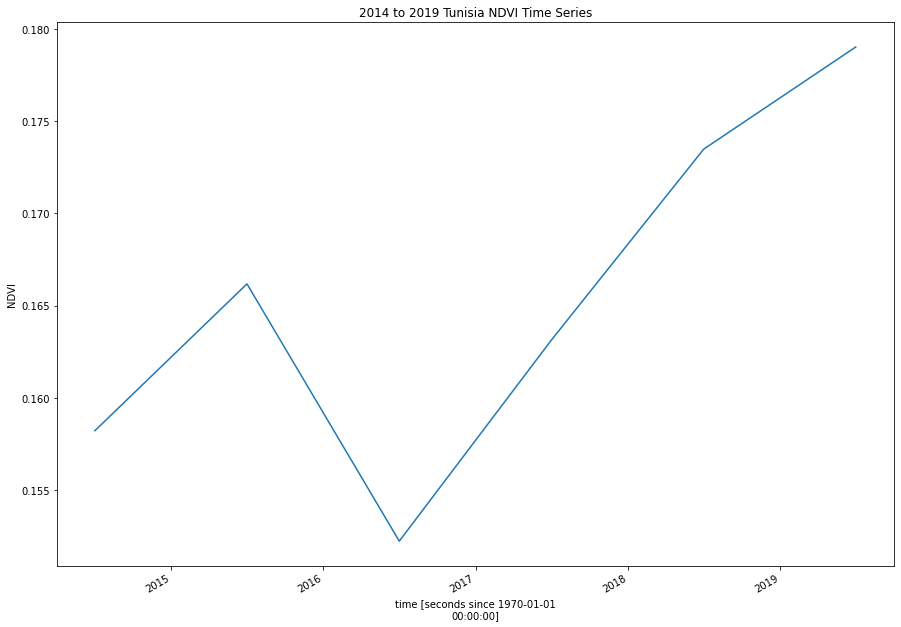

In [12]:
# Plot the NDVI time-series.
ds_ndvi.mean(dim=['x','y']).plot(size=10)
plt.title(f"{time_range[0]} to {time_range[1]} {country} NDVI Time Series");

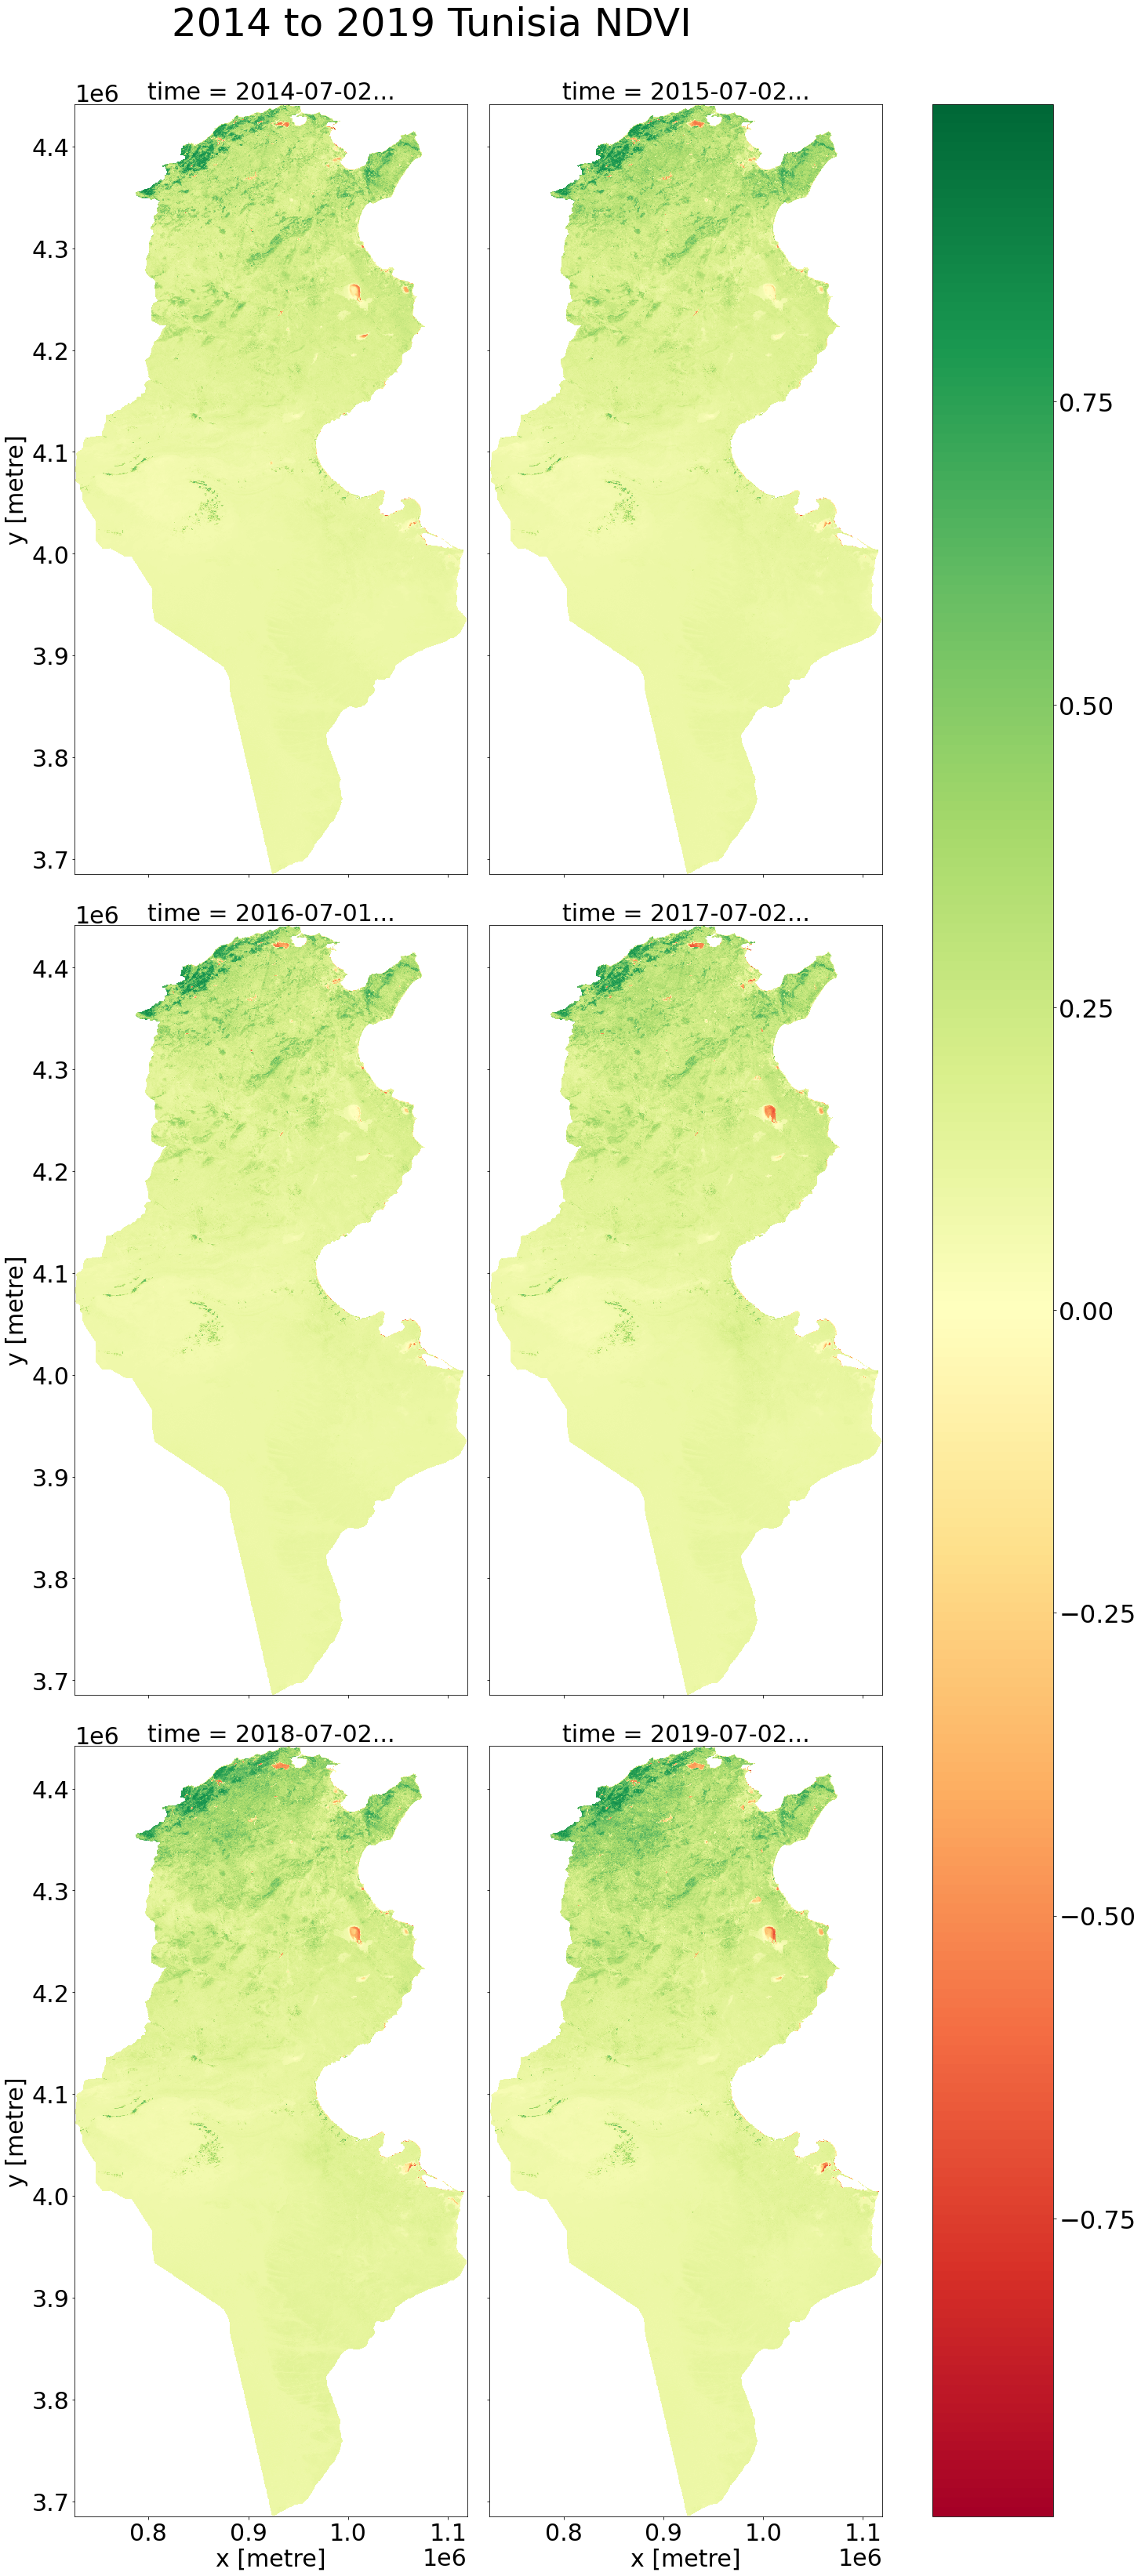

In [13]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 30})

# Define the number of columns in the figure.
ncols = 2 
# Get the number of subplots in the figure.
no_of_subplots = len(ds_ndvi.time.values)
# Use the number of columns and the number of subplots to determine the figure length,
# and the figure width.
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * (no_of_subplots/ncols)

# Plot the NDVI dataset.
fig = ds_ndvi.plot(col="time", col_wrap=ncols, add_colorbar=False, figsize=(figure_width,figure_length), cmap="RdYlGn")
# Figure title.
fig.fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} NDVI", x=0.4, y=1.02, size=50);
# Subplots' titles.
fig.set_titles(template='{coord} = {value}', size=30,  maxchar=20)

# Type of notation on the axes.
for i, ax in enumerate(fig.axes.flat):
    ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
    
# Color bar. 
cbar = plt.colorbar(fig._mappables[-1], ax=fig.axes)
cbar.ax.tick_params(labelsize=32)

In [14]:
# Classify the NDVI into 5 classes. 

# Define the labels and class values of NDVI Classes.
ndvi_class_labels = ["Very low", "Low", "Normal", "High", "Very high"]
ndvi_classes = [1, 2, 3, 4, 5]
# Define the colors to be used to represent the NDVI classes.
ndvi_colors = ['#a50026', '#f88d52', '#ffffbf', '#86cb66', '#006837']

classification_condition = [(ds_ndvi > -1) & (ds_ndvi <= 0.16),
                            (ds_ndvi > 0.16) & (ds_ndvi <= 0.30),
                            (ds_ndvi > 0.30) & (ds_ndvi <= 0.50),
                            (ds_ndvi > 0.50) & (ds_ndvi <= 0.66),
                            (ds_ndvi > 0.66) & (ds_ndvi <= 1)]


ds_ndvi_classified = xr.DataArray(data=np.select(classification_condition, ndvi_classes, default=np.nan),
                                  coords={"time": ds.time, "y": ds.y, "x": ds.x},
                                  dims=["time", "y", "x"]).astype(ds_ndvi.dtype).where(mask)

In [15]:
# Export the classified NDVI dataset for each year as a GeoTIFF.

# Loop through each year of the data. 
for i in range(len(ds_ndvi_classified.time)):
    # Get the data for a single year.
    singleTimestamp = ds_ndvi_classified.isel(time=i)
    year = singleTimestamp.time.dt.strftime('%Y').data
    # Define the file name for the GeoTIFF.
    fname = f"{output_dir}/{year}_{country.replace(' ', '')}_ndvi_classified.tif"
    print(f'Writing {fname}')
    # Write the GeoTIFF. 
    write_cog(singleTimestamp,fname=fname, overwrite=True)

Writing results/2014_Tunisia_ndvi_classified.tif
Writing results/2015_Tunisia_ndvi_classified.tif
Writing results/2016_Tunisia_ndvi_classified.tif
Writing results/2017_Tunisia_ndvi_classified.tif
Writing results/2018_Tunisia_ndvi_classified.tif
Writing results/2019_Tunisia_ndvi_classified.tif


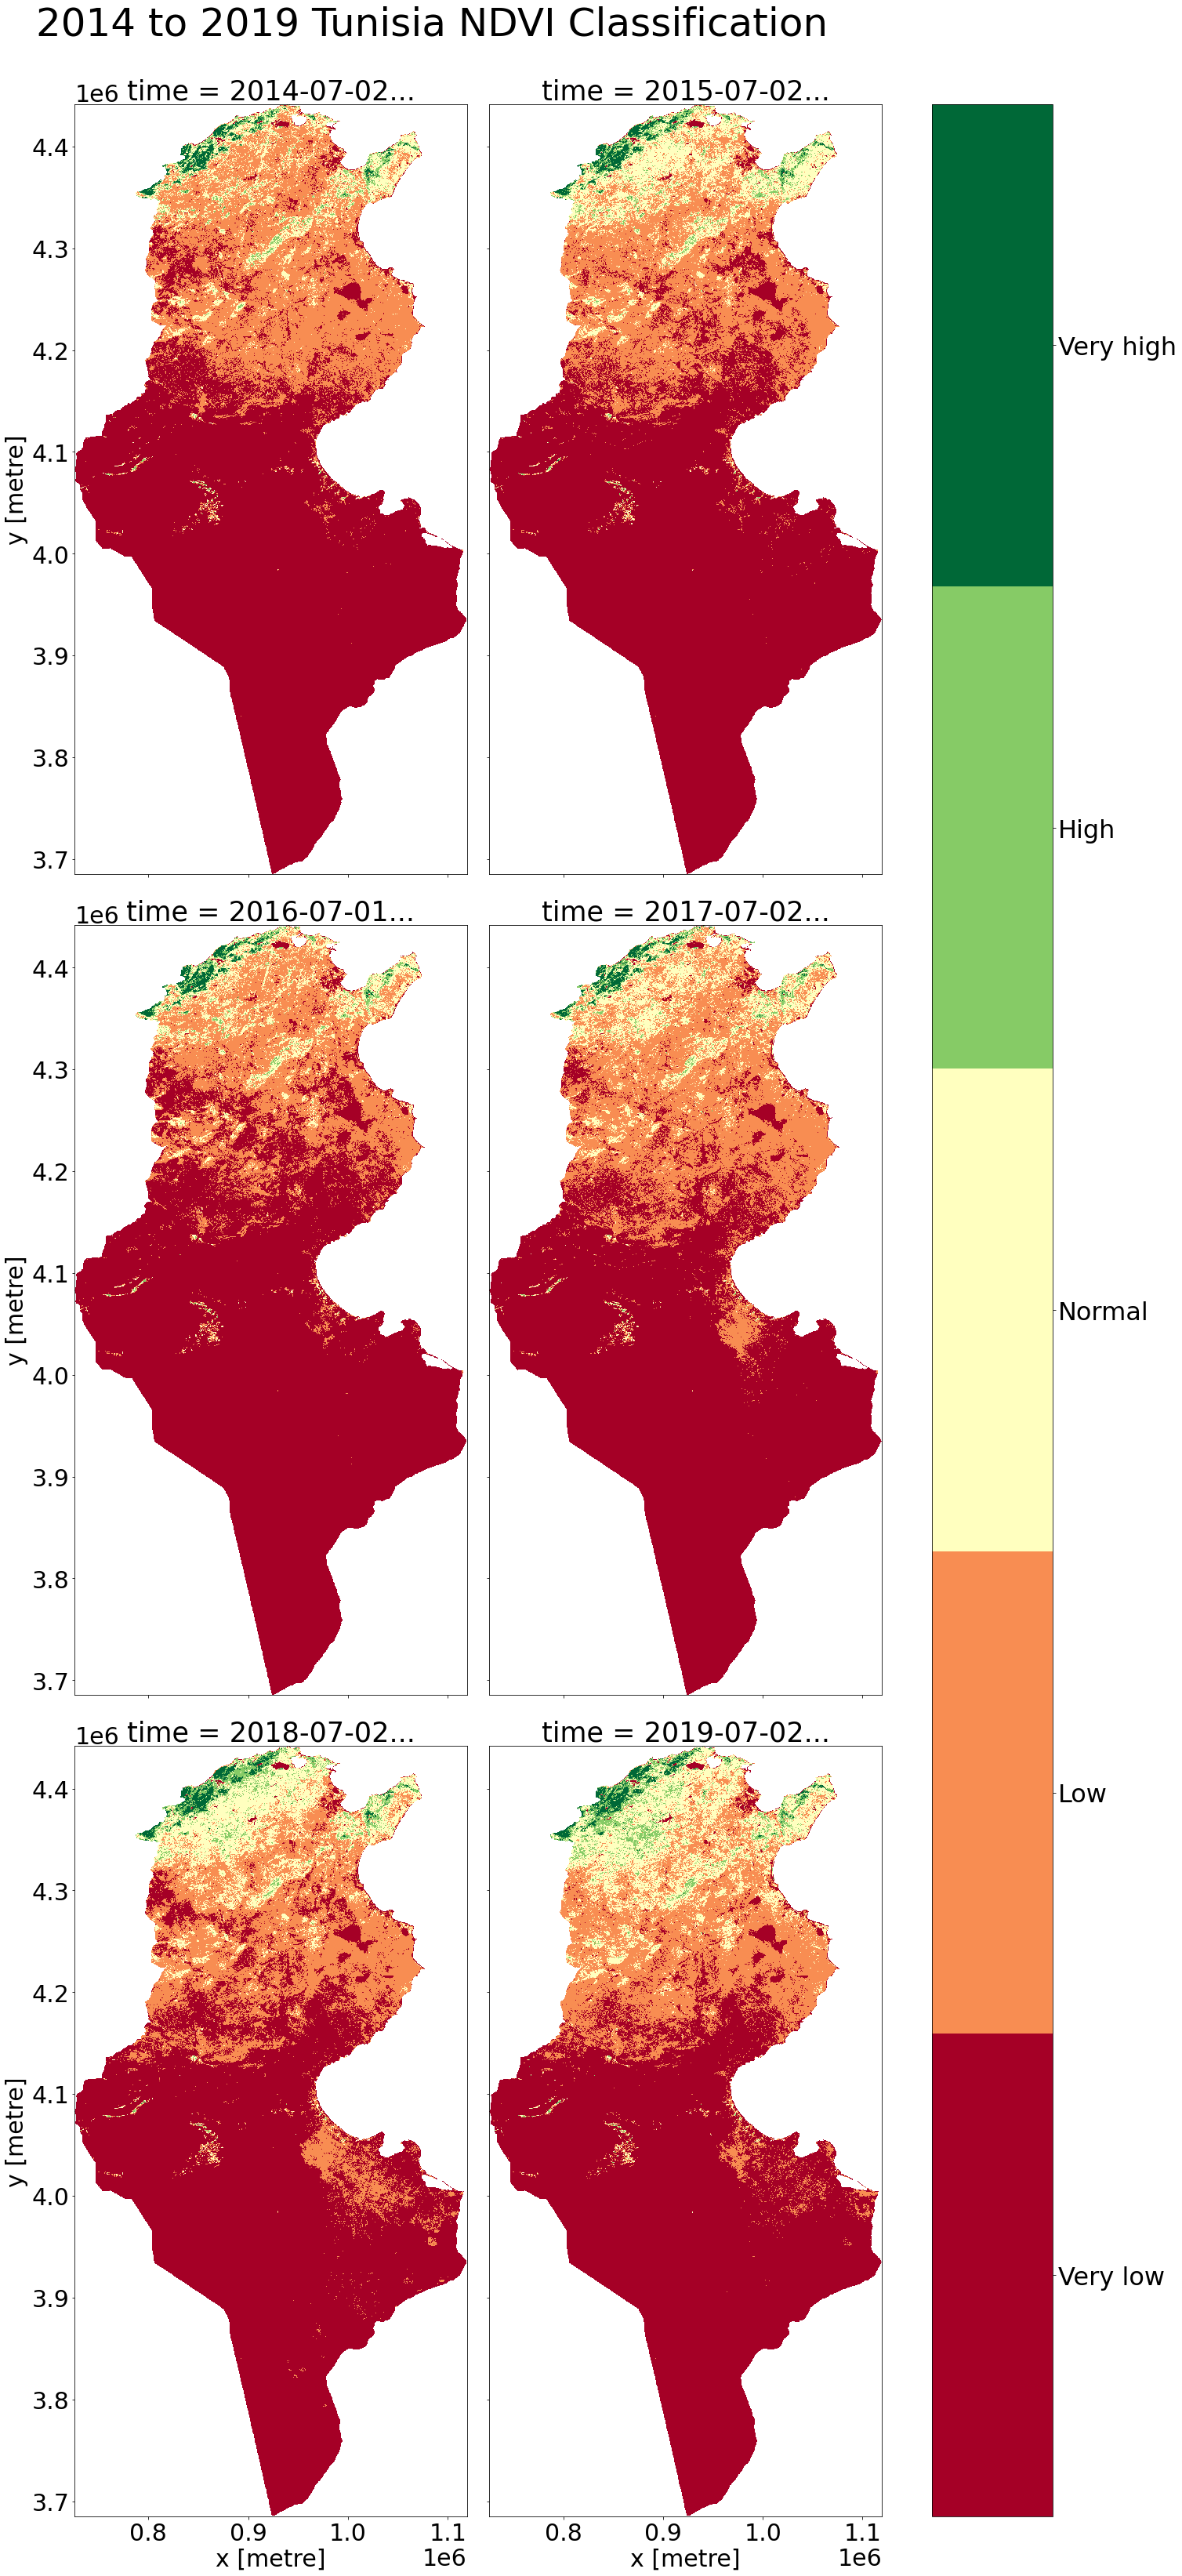

In [16]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 30})

# Define the color map to use to plot the NDVI classification.
cmap = mcolors.ListedColormap(colors=ndvi_colors, N=len(ndvi_classes))
bounds = np.arange(min(ndvi_classes) - 0.5, max(ndvi_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Visualise the classified NDVI xarray.DataArray.

# Define the number of columns in the figure.
ncols = 2 
# Get the number of subplots in the figure.
no_of_subplots = len(ds_ndvi_classified.time.values)
# Use the number of columns and the number of subplots to determine the figure length,
# and the figure width.
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * (no_of_subplots/ncols)

fig = ds_ndvi_classified.plot(col="time", col_wrap=ncols, add_colorbar=False, figsize=(figure_width,figure_length), cmap=cmap, norm=norm)
# Figure title.
fig.fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} NDVI Classification", x=0.4, y=1.02, size=50)
# Subplots' titles.
fig.set_titles(template='{coord} = {value}', size=35, maxchar=20)

# Type of notation on the axes.
for i, ax in enumerate(fig.axes.flat):
    ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))

# Color bar. 
cbar = plt.colorbar(fig._mappables[-1], ax=fig.axes, ticks=ndvi_classes)
cbar.set_ticklabels(ndvi_class_labels)
cbar.ax.tick_params(labelsize=32)

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_ndvi_classification.png")
plt.show()

Exporting animation to results/2014_to_2019_Tunisia_ndvi_classification.gif


  0%|          | 0/6 (0.0 seconds remaining at ? frames/s)

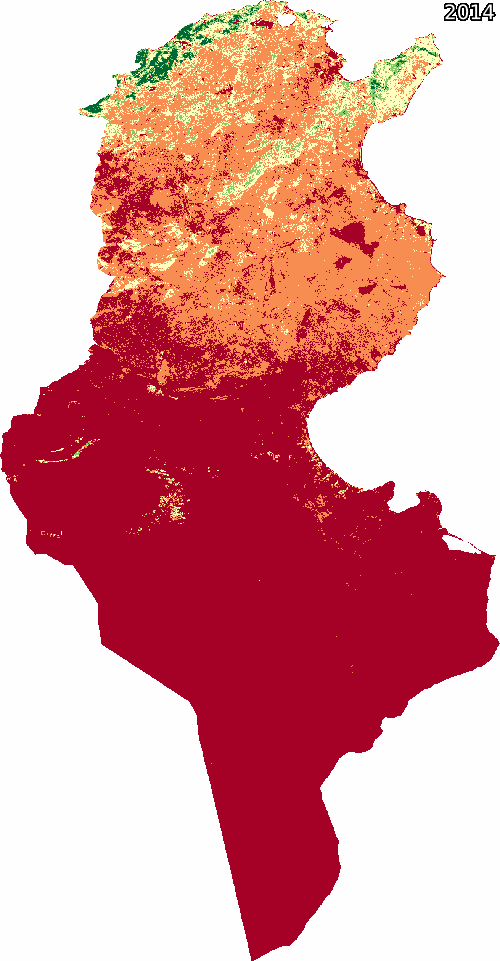

In [17]:
# Produce the classified NDVI time series animation.
xr_animation(ds=ds_ndvi_classified.to_dataset(name="NDVI"),
             bands="NDVI",
             output_path=f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_ndvi_classification.gif",
             show_date='%Y',
             interval= 1000,
             percentile_stretch=(0,1),
             imshow_kwargs=dict(cmap=cmap),
             show_colorbar=False)

# Plot the animated GIF.
plt.close()
Image(filename=f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_ndvi_classification.gif")

In [18]:
# Get the resolution i.e. actual ground distance represented by the length of a single pixel in meters.
pixel_length = query["resolution"][1]
# Conversion from metres sqaured to hectares.
m2_per_ha = 10000
# Get the actual ground area represented by each pixel.
area_per_pixel = (pixel_length ** 2) / m2_per_ha

In [19]:
# For each year, get the area of each NDVI class.

# Empty dictionary to store the loop results.
results = {}

# Group the ds_ndvi_classified xarray.DataArray by year.
for year, ds_year in ds_ndvi_classified.groupby("time.year"):
    # Convert the xarray.DataArray to a numpy array.
    ds_year_np = ds_year.values
    # Use the numpy np.unique function to return the pixel count for each NDVI class.
    counts = np.unique(ds_year_np, return_counts=True)
    # Calculate the area of each NDVI class.
    # Remove the last value as it represents the total area of pixels with the value np.nan.
    area = np.array(counts[1] * area_per_pixel)[:-1]
    results[year] = dict(zip(ndvi_class_labels, area))

In [20]:
# Convert the results dictionary into a pandas DataFrame.
results_df = pd.DataFrame.from_dict(results)
results_df.to_csv(f"{output_dir}/{country.replace(' ', '')}_ndvi_classification_areas.csv")
results_df

,2014,2015,2016,2017,2018,2019
Very low,10144998.0,10143018.0,11166156.0,9866052.0,9921861.0,9644490.0
Low,4117797.0,3610080.0,3179043.0,4165668.0,3699711.0,3527658.0
Normal,903987.0,1351620.0,853785.0,1164978.0,1425384.0,1776708.0
High,178893.0,225504.0,149679.0,161181.0,279486.0,365571.0
Very high,104148.0,119601.0,101160.0,91908.0,123381.0,135396.0


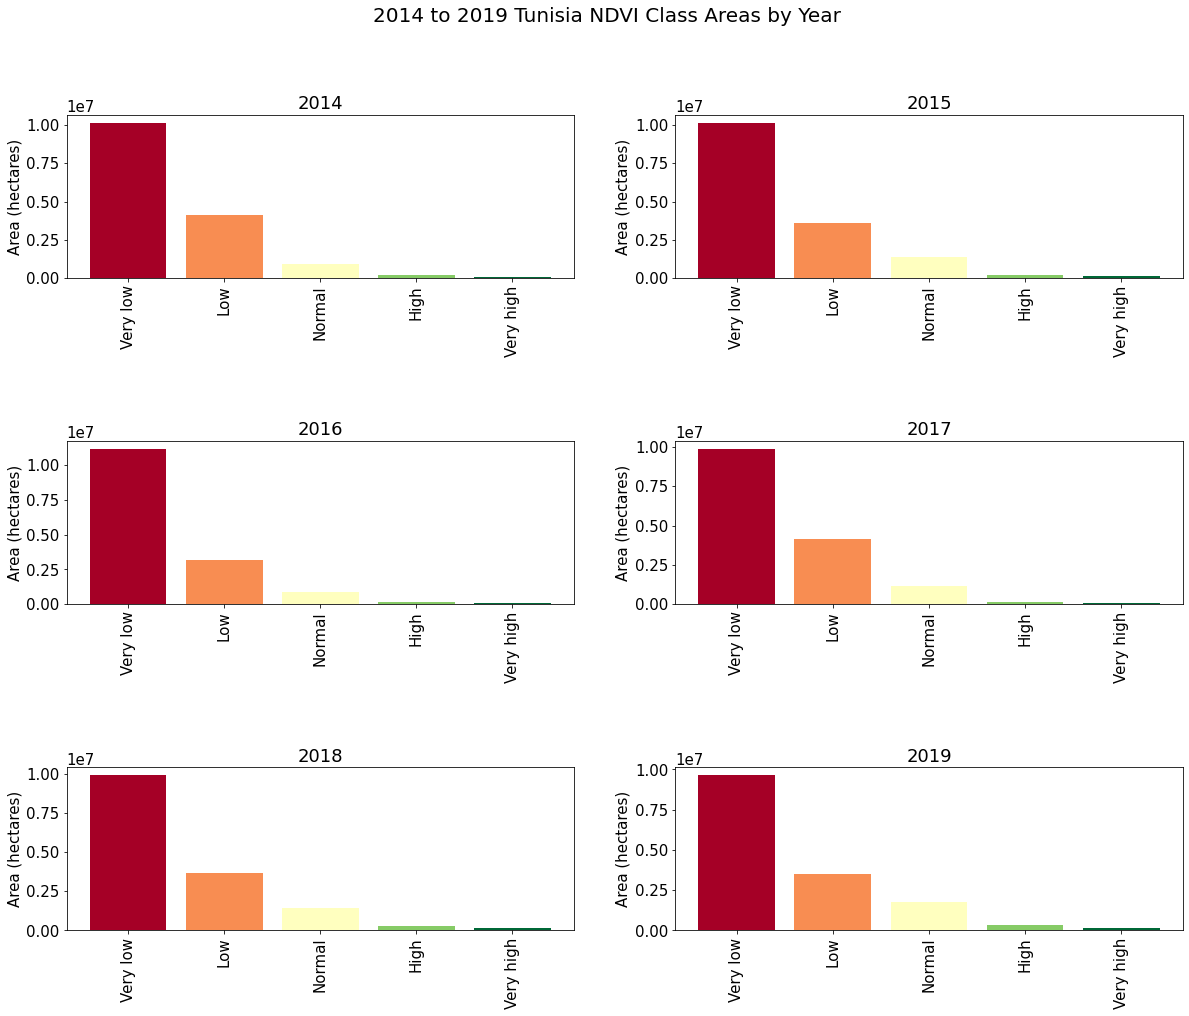

In [21]:
# For each year plot the area for each NDVI class. 

# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 15})

# Define the subplot grid.
ncols = 2
nrows = math.ceil(len(results_df.columns) / ncols)
# Use the number of subplot rows and columns to determine the figure length,
# and figure width. 
# For a single subplot width=10 and length=5.
figure_width = 10 * ncols
figure_length = 5 * nrows

fig = plt.figure(figsize=(figure_width, figure_length))

# Define the figure title.
fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} NDVI Class Areas by Year", fontsize=20)
plt.subplots_adjust(hspace=1)

# Loop through each column in the results_df pandas DataFrame.
for i, year in enumerate(results_df.columns):
    subplot = fig.add_subplot(nrows, ncols, i+1)
    # Set the subplot title and fontsize. 
    subplot.set_title(f"{year}", fontsize=18)
    # Set the y axis labels.
    subplot.set_ylabel("Area (hectares)")
    # Plot the column data as a bar graph.
    subplot.bar(x=results_df.index, height=results_df[year], color=ndvi_colors )
    # Rotate the xaxis labels.
    subplot.tick_params(axis='x', labelrotation=90)
    # Type of notation on the axes.
    subplot.ticklabel_format(axis="y", style='scientific', scilimits=(0, 0))

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_ndvi_class_areas_by_year.png")

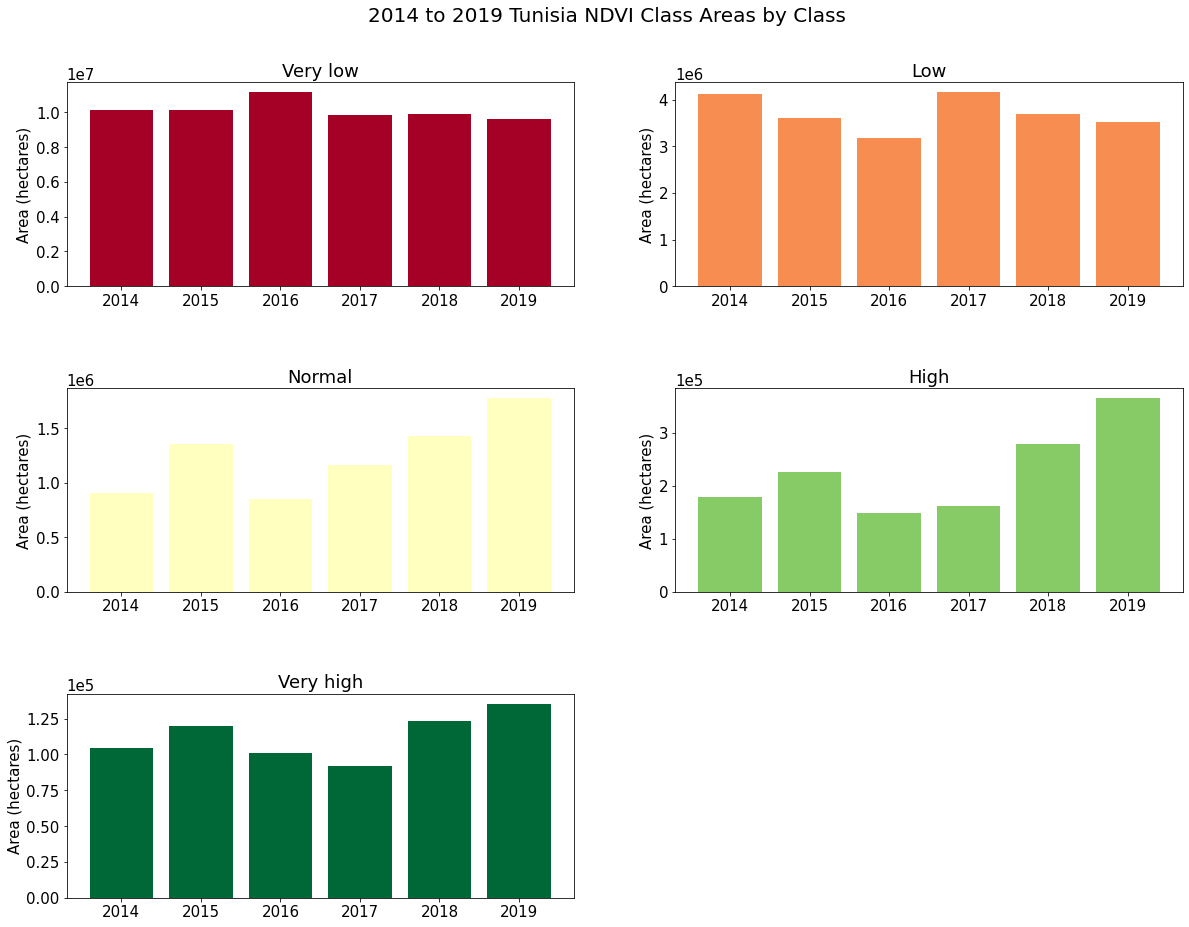

In [22]:
# Plot the area for each NDVI class over time.

# Transpose the results_df pandas dataframe.
results_df_1 = results_df.T

# Define the subplot grid.
ncols = 2
nrows = math.ceil(len(results_df_1.columns) / ncols)
# Use the number of subplot rows and columns to determine the figure length,
# and figure width. 
# For a single subplot width=10 and length=5.
figure_width = 10 * ncols
figure_length = 5 * nrows

fig = plt.figure(figsize=(figure_width, figure_length))
plt.subplots_adjust(hspace=0.5)

# Define the figure title.
fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} NDVI Class Areas by Class", fontsize=20, y=0.95)

# Loop through each column in the results_df_1 pandas DataFrame.
for i, ndvi_class  in enumerate(results_df_1.columns):
    subplot = fig.add_subplot(nrows, ncols, i+1)
    # Set the subplot title and fontsize. 
    subplot.set_title(f"{ndvi_class}", fontsize=18)
    # Set the y axis label.
    subplot.set_ylabel("Area (hectares)")
    # Plot the column data as a bar graph.
    subplot.bar(x=results_df_1.index, height=results_df_1[ndvi_class], color=ndvi_colors[i])
    # Type of notation on the axes.
    subplot.ticklabel_format(axis="y", style='scientific', scilimits=(0, 0))
    

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_ndvi_class_areas_by_class.png")

## Change Detection 

In [23]:
# Define the labels and values for the change classes.
change_labels = ["Stable", "Bad", "Excellent"]
change_classes = [0, 1, 2]
# Define the colors to be used to represent the change classes.
change_colors = ["orange", "red", "green"]

change_class_dict = dict(zip(change_labels, change_classes))

In [24]:
# Select the initial year from which to determine change from.
t0 = ds_ndvi_classified.sel(time=initial_year).squeeze().values

# Select the folow up year to use to determine if there was change in a pixel.
tn = ds_ndvi_classified.sel(time=followup_year).squeeze().values

In [25]:
# Generate an xarray.DataArray showing where the negative/bad, positive/excellent and stable changes occurred. 

# Define the change numpy array where all changes are assumed to be stable.
change = np.full(shape=t0.shape, fill_value=change_class_dict["Stable"])

# Define the negative/bad changes.
change = np.where((((t0 == 1) & (tn == 2)) | # Very low to Low 
                   ((t0 == 1) & (tn == 3)) | # Very low to Normal 
                   ((t0 == 1) & (tn == 4)) | # Very low to High
                   ((t0 == 1) & (tn == 5)) | # Very low to Very high
                   ((t0 == 2) & (tn == 1)) | # Low to Very low
                   ((t0 == 2) & (tn == 3)) | # Low to Normal
                   ((t0 == 2) & (tn == 4)) | # Low to High 
                   ((t0 == 2) & (tn == 5)) | # Low to Very high
                   ((t0 == 3) & (tn == 1)) | # Normal to Very low
                   ((t0 == 3) & (tn == 2)) | # Normal to Low 
                   ((t0 == 4) & (tn == 5))   # High to Very high 
                  ), change_class_dict["Bad"], change)


# Define the positive/excellent changes.
change = np.where((((t0 == 3) & (tn == 4)) | # Normal to High
                   ((t0 == 3) & (tn == 5)) | # Normal to Very high
                   ((t0 == 4) & (tn == 1)) | # High to Very low 
                   ((t0 == 4) & (tn == 2)) | # High to Low
                   ((t0 == 4) & (tn == 3)) | # High to Normal
                   ((t0 == 4) & (tn == 5)) | # High to Very high 
                   ((t0 == 5) & (tn == 1)) | # Very high to Very low
                   ((t0 == 5) & (tn == 2)) | # Very high to Low
                   ((t0 == 5) & (tn == 3)) | # Very high to Normal
                   ((t0 == 5) & (tn == 4))   # Very high to High
                  ), change_class_dict["Excellent"], change)

# Convert the change numpy array to an xarray.DataArray.
ds_change = xr.DataArray(data=change,
                         coords={"y": ds.y, "x": ds.x},
                         dims=["y", "x"]).astype(ds_ndvi.dtype).where(mask)

In [26]:
# Export the change xarray.DataArray as a GeoTIFF.
fname = f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_ndvi_change_detection.tif"

# Write GeoTIFF. 
write_cog(ds_change, fname=fname, overwrite=True)

PosixPath('results/2015_2019_Tunisia_ndvi_change_detection.tif')

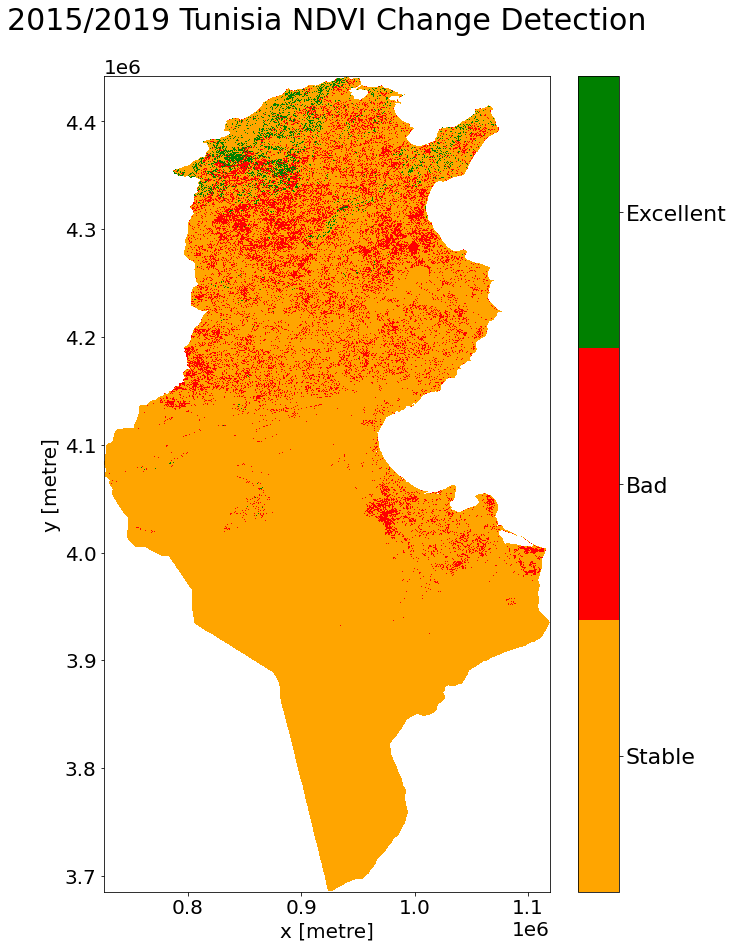

In [27]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 20})

# Define the color map to use to plot the change detection xarray.DataArray
cmap = mcolors.ListedColormap(colors=change_colors, N=len(change_classes))
bounds = np.arange(min(change_classes) - 0.5, max(change_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the change detection xarray.DataArray.
fig , ax = plt.subplots(figsize=(10, 15))
im = ds_change.plot(add_colorbar=False, ax=ax, cmap=cmap, norm=norm)
# Type of notation on the axes.
ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
plt.title(f"{initial_year}/{followup_year} {country} NDVI Change Detection", y=1.05, ha="center", size=30)

# Color bar.
cbar = plt.colorbar(im, ticks=change_classes)
cbar.set_ticklabels(change_labels)
cbar.ax.tick_params(labelsize=22)

plt.savefig(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_ndvi_change_detection.png")
plt.show()

In [28]:
# Get the area for each change class.

# Use the numpy np.unique function to return the pixel count for each change class.
counts = np.unique(ds_change, return_counts=True)
# Calculate the area of each change class.
# Remove the last value as it represents the area of pixels with the value np.nan.
area = np.array(counts[1] * area_per_pixel)[:-1]

# Store the results as a dictionary.
results = dict(zip(change_labels, area))

# Convert the results dictionary to a pandas DataFrame. 
results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Area (hectares)"])
results_df

,Area (hectares)
Stable,13589982.0
Bad,1607832.0
Excellent,252009.0


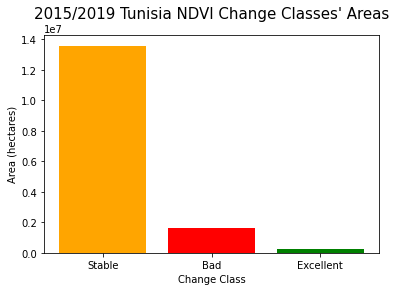

In [29]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 10})

fig = plt.figure()
subplot = fig.add_subplot(1, 1, 1)
subplot.bar(x=results_df.index, height=results_df["Area (hectares)"], color=change_colors )
# Set the x and y axis labels.
subplot.set_xlabel("Change Class")
subplot.set_ylabel("Area (hectares)")
# Set the title. 
subplot.set_title(f"{initial_year}/{followup_year} {country} NDVI Change Classes' Areas", y=1.05, size=15)
# Type of notation on the axes.
subplot.ticklabel_format(axis="y", style='scientific', scilimits=(0, 0))

plt.savefig(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_ndvi_change_areas.png");

## Area change matrix

In [30]:
# Change the default decimal precision used for printing dataframes.
pd.set_option("display.precision", 2)

# Styling function to change the background of a cell in a pandas dataframe.  
def ndvi_set_background_color(df):

    # Define the background colors to be used for the input dataframe cells.
    # based on the type of ndvi class change.
    dont_color = "background-color : white"
    stable = "background-color : orange"
    bad = "background-color : red"
    excellent = "background-color: green"

    # Create a copy of the input dataframe. 
    df1 = df.copy(deep=True)

    # Get the name of the first column.
    first_column = df1.columns[0]
    
    # Define the stable NDVI class changes.
    df1.loc[df1.index[df1[first_column] == "Very low"], "Very low"] = stable
    df1.loc[df1.index[df1[first_column] == "Low"], "Low"] = stable
    df1.loc[df1.index[df1[first_column] == "Normal"], "Normal"] = stable
    df1.loc[df1.index[df1[first_column] == "High"], "High"] = stable
    df1.loc[df1.index[df1[first_column] == "Very high"], "Very high"] = stable

    # Define the negative/bad NDVI class changes.
    df1.loc[df1.index[df1[first_column] == "Very low"], ["Low", "Normal", "High", "Very high"]] = bad
    df1.loc[df1.index[df1[first_column] == "Low"], [ "Very low", "Normal", "High", "Very high"]] = bad
    df1.loc[df1.index[df1[first_column] == "Normal"], [ "Very low", "Low"]] = bad
    df1.loc[df1.index[df1[first_column] == "High"], "Very high"] = bad
    # Define the positive NDVI class changes.
    df1.loc[df1.index[df1[first_column] == "Normal"], [ "High", "Very high"]] = excellent
    df1.loc[df1.index[df1[first_column] == "High"],  [ "Very low", "Low", "Normal"]] = excellent
    df1.loc[df1.index[df1[first_column] == "Very high"], [ "Very low", "Low", "Normal", "High"]] = excellent
    
    # Set the background color for the cells in the first column. 
    df1.loc[df1.index, first_column] = dont_color

    return df1

# Styling function to add a title to a pandas dataframe.
def make_pretty(styler, title):
    # Add a title to the dataframe.
    styler.set_caption(title) 
    # Increase the font size and bold the dataframe title.
    title_style = dict(selector="caption", props=[("font-weight", "bold"), 
                                                  ("font-size", "14px")])
    styler.set_table_styles([title_style])
    # Hide the dataframe index when displaying the dataframe.
    styler.hide_index() 
    return styler

In [31]:
# Generate the reference NDVI zone change matrix.
row_labels = ndvi_class_labels
column_labels = ndvi_class_labels

# Create a dataframe where all NDVI class changes are classified as stable.
ref_ndvi_change_matrix = pd.DataFrame(data="Stable", index=row_labels , columns=column_labels)
# Set the index column name
ref_ndvi_change_matrix.index.name = "Year of follow up <br> Initial Year"

# Define the negative/band NDVI class changes.
ref_ndvi_change_matrix.loc["Very low", ["Low", "Normal", "High", "Very high"]] = "Bad"
ref_ndvi_change_matrix.loc["Low", [ "Very low", "Normal", "High", "Very high"]] = "Bad"
ref_ndvi_change_matrix.loc["Normal", [ "Very low", "Low"]] = "Bad"
ref_ndvi_change_matrix.loc["High", "Very high"] = "Bad"

# Define the positive/excellent NDVI class changes.
ref_ndvi_change_matrix.loc["Normal", [ "High", "Very high"]] = "Excellent"
ref_ndvi_change_matrix.loc["High", [ "Very low", "Low", "Normal"]] = "Excellent"
ref_ndvi_change_matrix.loc["Very high", [ "Very low", "Low", "Normal", "High"]] = "Excellent"

# Reset the index.
ref_ndvi_change_matrix.reset_index(inplace=True)
# Style the dataframe.
ref_ndvi_change_matrix = ref_ndvi_change_matrix.style.apply(ndvi_set_background_color, axis=None).pipe(make_pretty, title="NDVI Zone Change Matrix")

In [32]:
# Generate the NDVI change matrix for the selected initial and follow up year.

# Map the NDVI class labels to the class values.
ndvi_class_dict = dict(zip(ndvi_classes, ndvi_class_labels))

change_results_per_class = {}
for ndvi_class in ndvi_classes:
    area_changed = {}
    for ndvi_change_class in ndvi_classes:
        # Get the pixels where change occored.
        change = np.where((t0 == ndvi_class) & (tn == ndvi_change_class), 1, np.nan)
        # Use the numpy np.unique function to return the pixel count for the changed pixels.
        counts = np.unique(change, return_counts=True)
        # Calculate the area of each NDVI class.
        # Remove the last value as it represents the area of pixels with the value np.nan.
        area = np.array(counts[1] * area_per_pixel)[:-1]
        # Check for empty arrays.
        if len(area)==1:
            area = area.item()
        else:
            area = 0
        area_changed[ndvi_class_dict[ndvi_change_class]] = area

    change_results_per_class[ndvi_class_dict[ndvi_class]] = area_changed
    

# Create a pandas dataframe from the results.    
ndvi_change_matrix = pd.DataFrame.from_dict(change_results_per_class)
# Set the index column name.
ndvi_change_matrix.index.name = f"{followup_year} <br> {initial_year}"
# Reset the index. 
ndvi_change_matrix.reset_index(inplace=True)
# Style the dataframe.
ndvi_change_matrix = ndvi_change_matrix.style.apply(ndvi_set_background_color, axis=None).pipe(make_pretty, title=f"{initial_year} to {followup_year} {country} NDVI Zone Change Matrix (hectares)")

In [33]:
display(ref_ndvi_change_matrix)

Year of follow up Initial Year,Very low,Low,Normal,High,Very high
Very low,Stable,Bad,Bad,Bad,Bad
Low,Bad,Stable,Bad,Bad,Bad
Normal,Bad,Bad,Stable,Excellent,Excellent
High,Excellent,Excellent,Excellent,Stable,Bad
Very high,Excellent,Excellent,Excellent,Excellent,Stable


In [34]:
display(ndvi_change_matrix)

2019 2015,Very low,Low,Normal,High,Very high
Very low,9493515.00,149598.00,1314.00,54.00,9.00
Low,645723.00,2766753.00,113688.00,1485.00,9.00
Normal,3627.00,675243.00,1059111.00,37764.00,963.00
High,153.00,18288.00,175581.00,161766.00,9783.00
Very high,0.00,198.00,1926.00,24435.00,108837.00


In [35]:
# Export the above NDVI zone change matrices as csv files.
ref_ndvi_change_matrix.data.to_csv(f"{output_dir}/{country.replace(' ', '')}_reference_ndvi_change_matrix.csv", index=False)
ndvi_change_matrix.data.to_csv(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_ndvi_change_matrix.csv", index=False)